In [1]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pomegranate import GeneralMixtureModel, LogNormalDistribution, GammaDistribution, NormalDistribution
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)

In this section we'll check for performance increase when apply two kinds of data transformation:

1. Apply a standard scaler to the data
2. TODO: Add a PCA transformation to the data
3. TODO: Evaluate the clusters. Aske mentioned something with variance.

In [2]:
# Standardize the data
scaler = MinMaxScaler()
# scaler = StandardScaler()
data = {
    "scaled": pd.DataFrame(scaler.fit_transform(df), columns=df.columns) + 0.001,
    "raw": df}

# add pca transformed data
for dimension in range(1, len(wine.feature_names)):
    pca = PCA(n_components=dimension)
    data[f"pca_{dimension}"] = pd.DataFrame(pca.fit_transform(data['scaled']), columns=[f"pca_{i}" for i in range(dimension)])

for key in data.keys():
    data[key]["target"] = wine.target

In [3]:
for datatype in data:
    if not data[datatype].min().min() < 0:
        print(f'{datatype} dont have negative values')

scaled dont have negative values
raw dont have negative values


# How many clusters?

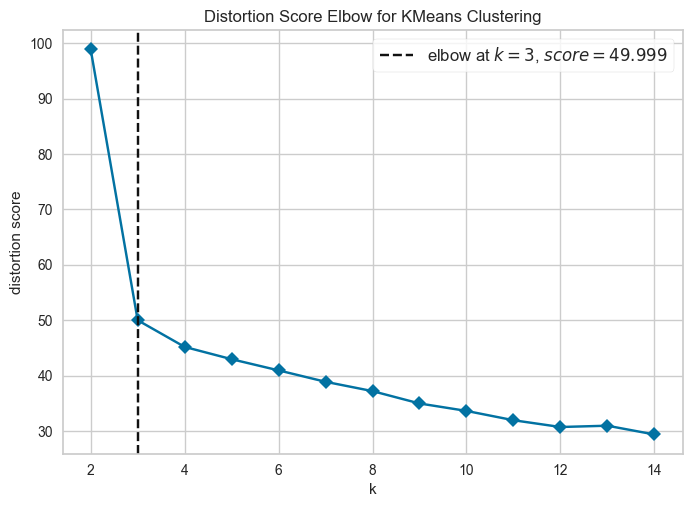

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
visualizer = KElbowVisualizer(KMeans(random_state=32), k=(2,15), metric='distortion', timings=False)
visualizer.fit(data["scaled"])        
visualizer.show()        

# Evaluate all models on k=3

In [19]:
from sklearn.metrics import adjusted_rand_score


distributions = {
    "lognormal": LogNormalDistribution,
    "gamma":GammaDistribution
    }

component = 3

sklearn_models = [
    ("K-Means",KMeans), 
    ("GMM + K-Means",GaussianMixture),
    ("GMM",GaussianMixture),
    ("AGG",AgglomerativeClustering)]

num_iters = 25

results = {'distribution':[],
           'mutual_information':[],
           'datatype':[],
           'adjusted_rand_score':[],}


for datatype, df in data.items():

    features, labels = df.drop('target', axis=1, inplace=False), df['target']
        
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for idx, (train_idx, test_idx) in enumerate(skf.split(features, labels)):
        
        X_train, X_test, y_train, y_test = features.iloc[train_idx], features.iloc[test_idx], labels.iloc[train_idx], labels.iloc[test_idx]

        for name, distribution in distributions.items():
            
            try:
                model = GeneralMixtureModel.from_samples(distribution, n_components=component, X=X_train, )
                model.fit(X_train)
                y_pred = model.predict(X_test)
                score = adjusted_mutual_info_score(y_test, y_pred)  
            
            except ZeroDivisionError:
                print(f'Division Error: {datatype} {name} {component} {idx}')
                score = 0
            
            except Exception as e:
                print(f'Error: {datatype} {name} {component} {idx} - {e}')
                score = 0

            results['distribution'].append(name)
            results['mutual_information'].append(score)
            results['adjusted_rand_score'].append(adjusted_rand_score(y_test, y_pred))
            results['datatype'].append(datatype)

        for name, model in sklearn_models:
            
            MODEL = model()

            if name == 'GMM + K-Means':                    
                MODEL.n_components = component
                MODEL.init_params = 'kmeans'
                MODEL.random_state = 32

            if name == 'GMM':
                MODEL.n_components = component
                MODEL.init_params = 'random'
                MODEL.random_state = 32
            
            if name == 'K-Means':
                # kmeans
                MODEL.n_clusters = component
                MODEL.random_state = 32
            
            if name == "AGG":
                MODEL.n_clusters = component


            if name == "AGG":
                y_pred = MODEL.fit_predict(X_test)
            else:
                MODEL.fit(X_train)
                y_pred = MODEL.predict(X_test)

            score = adjusted_mutual_info_score(y_test, y_pred)
            score1 = adjusted_rand_score(y_test, y_pred)

            results['distribution'].append(name)
            results['mutual_information'].append(score)
            results['adjusted_rand_score'].append(score1)
            results['datatype'].append(datatype)
            
results = pd.DataFrame(results)

In [20]:
results

,distribution,mutual_information,datatype,adjusted_rand_score
0,lognormal,1.000000,scaled,1.000000
1,gamma,1.000000,scaled,1.000000
2,K-Means,0.837851,scaled,0.827967
3,GMM + K-Means,1.000000,scaled,1.000000
4,GMM,0.337109,scaled,0.250735
...,...,...,...,...
835,gamma,0.000000,pca_12,0.000000
836,K-Means,0.823294,pca_12,0.811871
837,GMM + K-Means,1.000000,pca_12,1.000000
838,GMM,0.446386,pca_12,0.298464


In [21]:
results = results.groupby(['distribution','datatype']).mean().sort_values('mutual_information',ascending=False)
results = results[results["mutual_information"] > 0.1]
results.to_csv("results/rq4-models.csv",index=True)
results

mutual_information  adjusted_rand_score
distribution  datatype                                         
GMM + K-Means pca_10              0.983596             0.983215
              pca_11              0.967381             0.966012
              pca_9               0.966802             0.964564
              scaled              0.966413             0.962698
              pca_12              0.950989             0.949022
              pca_6               0.924979             0.914365
gamma         scaled              0.902533             0.896993
GMM + K-Means pca_7               0.900090             0.892400
              pca_8               0.899587             0.890967
lognormal     scaled              0.886725             0.857853
GMM + K-Means pca_2               0.885562             0.878556
K-Means       pca_9               0.884107             0.876946
              pca_5               0.876279             0.863999
              pca_11              0.867892             0.859743
              pca_8               0.867892             0.859743
              pca_10              0.867892             0.859743
lognormal     raw                 0.867704             0.859603
K-Means       pca_4               0.867403             0.848875
              pca_2               0.867403             0.848875
GMM + K-Means pca_3               0.852078             0.844200
gamma         raw                 0.851820             0.832401
K-Means       scaled              0.851677             0.842539
              pca_12              0.851677             0.842539
              pca_6               0.851677             0.842539
              pca_7               0.851098             0.841092
              pca_3               0.834089             0.816535
GMM           pca_3               0.833784             0.826057
AGG           pca_3               0.826738             0.802461
GMM + K-Means pca_5               0.823338             0.807534
AGG           pca_5               0.811065             0.783689
              pca_10              0.803829             0.790671
              scaled              0.801843             0.780354
              pca_12              0.801843             0.780354
              pca_11              0.801843             0.780354
              pca_2               0.787282             0.765627
              pca_4               0.783587             0.744771
              pca_7               0.778361             0.750075
              pca_9               0.778160             0.756896
              pca_6               0.763684             0.738185
              pca_8               0.760257             0.732129
GMM + K-Means pca_4               0.708938             0.664355
GMM           pca_4               0.681720             0.651744
GMM + K-Means raw                 0.617127             0.541037
AGG           pca_1               0.592933             0.527412
GMM           pca_6               0.589884             0.520236
GMM + K-Means pca_1               0.588536             0.509917
K-Means       pca_1               0.582607             0.529603
GMM           pca_5               0.570813             0.541807
              pca_2               0.496613             0.360804
              pca_7               0.485513             0.416303
AGG           raw                 0.426606             0.356728
GMM           pca_8               0.421474             0.353509
K-Means       raw                 0.420022             0.359549
GMM           raw                 0.407957             0.319791
              scaled              0.407957             0.319791
              pca_10              0.383023             0.302611
              pca_12              0.357288             0.283627
              pca_11              0.323003             0.247095
              pca_9               0.321222             0.261120
              pca_1               0.291091             0.212506

In [23]:
pivot_df = results.pivot_table(index='datatype', columns='distribution', values='mutual_information').round(3)
pivot_df= pivot_df.reindex(
    ['raw','scaled','pca_1','pca_2','pca_3','pca_4','pca_5','pca_6','pca_7','pca_8','pca_9','pca_10','pca_11','pca_12'],
    columns=['K-Means','GMM + K-Means','GMM',"AGG",'lognormal','gamma',]
    )
pivot_df.rename(columns={'lognormal':'LN','gamma':'G'}, inplace=True)
pivot_df=pivot_df.fillna('-')
pivot_df.to_latex("results/rq4-models.tex", index=True)
pivot_df

distribution,K-Means,GMM + K-Means,GMM,AGG,LN,G
datatype,,,,,,
raw,0.420,0.617,0.408,0.427,0.868,0.852
scaled,0.852,0.966,0.408,0.802,0.887,0.903
pca_1,0.583,0.589,0.291,0.593,-,-
pca_2,0.867,0.886,0.497,0.787,-,-
pca_3,0.834,0.852,0.834,0.827,-,-
pca_4,0.867,0.709,0.682,0.784,-,-
pca_5,0.876,0.823,0.571,0.811,-,-
pca_6,0.852,0.925,0.590,0.764,-,-
pca_7,0.851,0.900,0.486,0.778,-,-
